In [1]:
%matplotlib inline
import os
import numpy as np
import glob
import PIL.Image as Image
import random
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from skorch import NeuralNetClassifier

We provide you with a class that can load the *hotdog/not hotdog* dataset you should use

In [2]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='/scratch/hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something else than $128\times128$ images.

In [3]:
size = 256
train_transform = transforms.Compose([
                                    transforms.RandomResizedCrop((size,size)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[.5,.5,.5], std=[.5,.5,.5])])
test_transform = transforms.Compose([
                                    transforms.Resize(size),
                                    transforms.CenterCrop((size, size)), 
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[.5,.5,.5], std=[.5,.5,.5])])

batch_size = 64
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

In [4]:
print("Length train set: {}".format(len(trainset)))
print("Length test set: {}".format(len(testset)))

Length train set: 2047
Length test set: 1862


Let's look at some images from our data 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

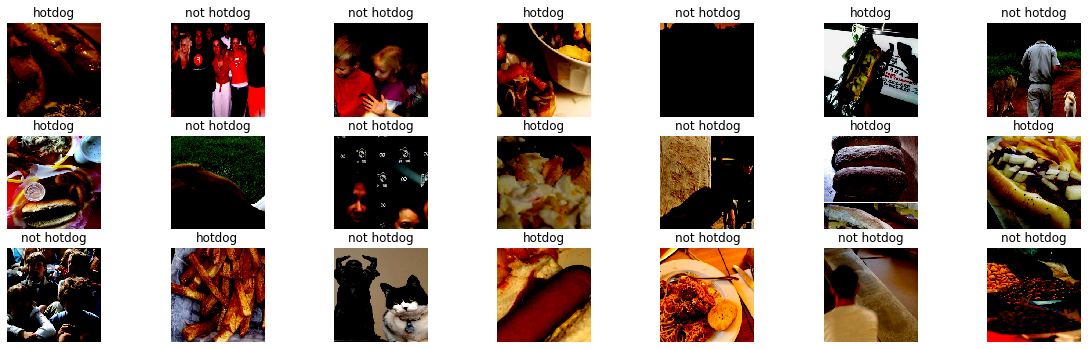

In [5]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')

In [6]:
# setting device
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU.")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')   

The code will run on GPU.


<h2> Neural net

In [7]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [8]:
def train(model, optimizer, loss_function, num_epochs=5):
    train_acc_all, test_acc_all = [], []
    
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        
        train_correct, test_correct = 0, 0
        model.train()
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data = data.to(device)
            target = target.to(device)
            
            # set the parameter gradients to zero
            optimizer.zero_grad()
            
            output = model(data)
            loss_size = loss_function(output, target)
            loss_size.backward()
            optimizer.step()
            
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().item()
        
        model.eval()
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            
            with torch.no_grad(): # desactivating backpropagation
                output = model(data)
            
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().item()
        
        train_acc = train_correct / len(trainset)
        test_acc = test_correct / len(testset)
        print("Accuracy train: {train:.1f}%\t test: {test:.1f}%".format(test=100*test_acc, train=100*train_acc))
        
        train_acc_all.append(train_acc)
        test_acc_all.append(test_acc)
    
    return train_acc_all, test_acc_all

In [9]:
model = Network()
model.to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.0001)

train_acc, test_acc = train(model, optimizer, loss_function, num_epochs=150)

torch.save(model.state_dict(), "hotdog.pth")

Accuracy train: 64.4%	 test: 67.7%


Accuracy train: 71.3%	 test: 71.0%


Accuracy train: 73.1%	 test: 73.8%


Accuracy train: 75.0%	 test: 75.2%


Accuracy train: 75.2%	 test: 72.6%


Accuracy train: 77.7%	 test: 76.7%


Accuracy train: 77.0%	 test: 75.4%


Accuracy train: 76.4%	 test: 75.8%


Accuracy train: 78.6%	 test: 77.0%


Accuracy train: 77.9%	 test: 77.8%


Accuracy train: 79.6%	 test: 78.6%


Accuracy train: 79.2%	 test: 78.5%


Accuracy train: 79.9%	 test: 77.4%


Accuracy train: 80.1%	 test: 75.2%


Accuracy train: 79.1%	 test: 79.3%


Accuracy train: 80.6%	 test: 79.2%


Accuracy train: 81.2%	 test: 77.9%


Accuracy train: 81.2%	 test: 80.7%


Accuracy train: 80.9%	 test: 79.9%


Accuracy train: 82.3%	 test: 80.3%


Accuracy train: 81.1%	 test: 79.9%


Accuracy train: 81.9%	 test: 80.8%


Accuracy train: 82.9%	 test: 80.9%


Accuracy train: 82.6%	 test: 81.0%


Accuracy train: 83.5%	 test: 81.2%


Accuracy train: 82.7%	 test: 80.1%


Accuracy train: 81.9%	 test: 81.4%


Accuracy train: 83.4%	 test: 77.4%


Accuracy train: 84.8%	 test: 82.6%


Accuracy train: 84.1%	 test: 77.2%


Accuracy train: 84.1%	 test: 82.1%


Accuracy train: 84.3%	 test: 79.1%


Accuracy train: 83.9%	 test: 81.5%


Accuracy train: 85.2%	 test: 82.0%


Accuracy train: 84.7%	 test: 81.1%


Accuracy train: 84.2%	 test: 82.4%


Accuracy train: 86.3%	 test: 82.2%


Accuracy train: 85.9%	 test: 82.3%


Accuracy train: 86.1%	 test: 82.1%


Accuracy train: 86.2%	 test: 82.9%


Accuracy train: 86.5%	 test: 83.2%


Accuracy train: 87.2%	 test: 82.4%


Accuracy train: 86.9%	 test: 82.9%


Accuracy train: 85.6%	 test: 81.4%


Accuracy train: 86.5%	 test: 82.1%


Accuracy train: 86.5%	 test: 83.0%


Accuracy train: 87.5%	 test: 83.7%


Accuracy train: 85.7%	 test: 83.0%


Accuracy train: 88.0%	 test: 83.9%


Accuracy train: 86.4%	 test: 83.8%


Accuracy train: 87.6%	 test: 82.4%


Accuracy train: 87.4%	 test: 82.4%


Accuracy train: 88.9%	 test: 83.7%


Accuracy train: 88.6%	 test: 84.2%


Accuracy train: 87.4%	 test: 81.7%


Accuracy train: 88.4%	 test: 84.4%


Accuracy train: 88.5%	 test: 80.8%


Accuracy train: 88.4%	 test: 82.9%


Accuracy train: 89.5%	 test: 83.8%


Accuracy train: 90.1%	 test: 84.3%


Accuracy train: 89.5%	 test: 83.6%


Accuracy train: 89.8%	 test: 83.4%


Accuracy train: 89.7%	 test: 82.7%


Accuracy train: 90.7%	 test: 83.5%


Accuracy train: 89.9%	 test: 83.2%


Accuracy train: 90.7%	 test: 84.0%


Accuracy train: 89.6%	 test: 82.0%


Accuracy train: 90.1%	 test: 84.0%


Accuracy train: 91.7%	 test: 83.1%


Accuracy train: 91.8%	 test: 83.7%


Accuracy train: 90.9%	 test: 81.7%


Accuracy train: 90.3%	 test: 84.1%


Accuracy train: 90.7%	 test: 83.7%


Accuracy train: 91.4%	 test: 84.5%


Accuracy train: 92.0%	 test: 83.1%


Accuracy train: 90.6%	 test: 84.4%


Accuracy train: 91.4%	 test: 83.6%


Accuracy train: 92.7%	 test: 83.1%


Accuracy train: 91.5%	 test: 84.5%


Accuracy train: 92.5%	 test: 84.4%


Accuracy train: 93.6%	 test: 84.2%


Accuracy train: 91.3%	 test: 84.4%


Accuracy train: 91.9%	 test: 84.1%


Accuracy train: 92.3%	 test: 84.0%


Accuracy train: 92.8%	 test: 83.4%


Accuracy train: 92.5%	 test: 84.9%


Accuracy train: 92.8%	 test: 83.8%


Accuracy train: 92.5%	 test: 83.7%


Accuracy train: 92.6%	 test: 83.7%


Accuracy train: 93.3%	 test: 82.7%


Accuracy train: 92.1%	 test: 83.8%


Accuracy train: 92.3%	 test: 83.2%


Accuracy train: 92.6%	 test: 83.7%


Accuracy train: 92.7%	 test: 83.8%


Accuracy train: 93.6%	 test: 83.2%


Accuracy train: 94.3%	 test: 82.9%


Accuracy train: 92.8%	 test: 84.2%


Accuracy train: 94.3%	 test: 84.0%


Accuracy train: 93.7%	 test: 84.3%


Accuracy train: 93.6%	 test: 84.1%


Accuracy train: 93.4%	 test: 83.5%


Accuracy train: 92.6%	 test: 85.1%


Accuracy train: 93.3%	 test: 84.5%


Accuracy train: 94.4%	 test: 82.9%


Accuracy train: 94.1%	 test: 84.6%


Accuracy train: 94.0%	 test: 84.5%


Accuracy train: 93.9%	 test: 83.8%


Accuracy train: 94.3%	 test: 85.1%


Accuracy train: 93.8%	 test: 82.7%


Accuracy train: 93.7%	 test: 84.6%


Accuracy train: 94.1%	 test: 85.2%


Accuracy train: 94.1%	 test: 82.5%


Accuracy train: 94.4%	 test: 83.8%


Accuracy train: 93.8%	 test: 84.5%


Accuracy train: 94.4%	 test: 84.2%


Accuracy train: 95.3%	 test: 84.0%


Accuracy train: 94.3%	 test: 82.5%


Accuracy train: 93.3%	 test: 83.7%


Accuracy train: 93.6%	 test: 84.0%


Accuracy train: 94.0%	 test: 84.3%


Accuracy train: 94.6%	 test: 83.7%


Accuracy train: 95.1%	 test: 83.9%


Accuracy train: 93.9%	 test: 82.4%


Accuracy train: 94.6%	 test: 84.3%


Accuracy train: 94.5%	 test: 83.2%


Accuracy train: 94.3%	 test: 83.9%


Accuracy train: 94.7%	 test: 83.8%


Accuracy train: 95.1%	 test: 83.6%


Accuracy train: 94.4%	 test: 84.4%


Accuracy train: 95.1%	 test: 85.2%


Accuracy train: 95.6%	 test: 83.8%


Accuracy train: 94.6%	 test: 84.5%


Accuracy train: 95.6%	 test: 84.2%


Accuracy train: 95.0%	 test: 82.8%


Accuracy train: 94.1%	 test: 84.8%


Accuracy train: 95.5%	 test: 83.2%


Accuracy train: 94.3%	 test: 84.2%


Accuracy train: 95.0%	 test: 84.6%


Accuracy train: 95.6%	 test: 84.6%


Accuracy train: 94.4%	 test: 82.9%


Accuracy train: 95.2%	 test: 85.0%


Accuracy train: 95.9%	 test: 84.5%


Accuracy train: 96.0%	 test: 84.2%


Accuracy train: 96.0%	 test: 84.5%


Accuracy train: 94.9%	 test: 84.8%


Accuracy train: 95.2%	 test: 84.6%


Accuracy train: 95.2%	 test: 83.1%


Accuracy train: 95.2%	 test: 84.7%


Accuracy train: 94.7%	 test: 84.1%


Accuracy train: 94.8%	 test: 83.7%



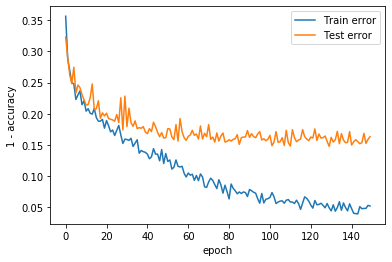

In [16]:
error_train = [1-elt for elt in train_acc]
error_test = [1-elt for elt in test_acc]

plt.figure()
plt.plot(error_train)
plt.plot(error_test)
plt.legend(["Train error", "Test error"]);
plt.xlabel("epoch");
plt.ylabel("1 - accuracy");
plt.savefig("accuracy_model.png");

In [18]:
# tuning optimizer
# running each optimizer 3 times to be more precise
train_acc, test_acc = np.zeros((3,3)), np.zeros((3,3))

# adam
for i in range(3):
    model = Network()
    model.to(device)
    
    loss_function = torch.nn.CrossEntropyLoss()
    opt_ = torch.optim.Adam(model.parameters(), lr=.0001)
    
    tr, te = train(model, opt_, loss_function, num_epochs=10)
    train_acc[i][0] = tr[-1]
    test_acc[i][0] = te[-1]

# SGD
for i in range(3):
    model = Network()
    model.to(device)
    
    loss_function = torch.nn.CrossEntropyLoss()
    opt_ = torch.optim.SGD(model.parameters(), lr=.01, momentum=.9)
    
    tr, te = train(model, opt_, loss_function, num_epochs=10)
    train_acc[i][1] = tr[-1]
    test_acc[i][1] = te[-1]
    
# RMSprop
for i in range(3):
    model = Network()
    model.to(device)
    
    loss_function = torch.nn.CrossEntropyLoss()
    opt_ = torch.optim.RMSprop(model.parameters(), lr=.00005)
    
    tr, te = train(model, opt_, loss_function, num_epochs=10)
    train_acc[i][2] = tr[-1]
    test_acc[i][2] = te[-1]

Accuracy train: 66.6%	 test: 70.4%


Accuracy train: 75.3%	 test: 72.2%


Accuracy train: 75.2%	 test: 74.9%


Accuracy train: 77.3%	 test: 71.1%


Accuracy train: 78.8%	 test: 74.1%


Accuracy train: 78.4%	 test: 76.7%


Accuracy train: 80.5%	 test: 75.9%


Accuracy train: 79.7%	 test: 77.3%


Accuracy train: 80.4%	 test: 77.8%


Accuracy train: 80.8%	 test: 75.5%



Accuracy train: 70.1%	 test: 57.7%


Accuracy train: 74.6%	 test: 74.1%


Accuracy train: 75.7%	 test: 71.1%


Accuracy train: 77.6%	 test: 75.5%


Accuracy train: 78.9%	 test: 76.1%


Accuracy train: 78.7%	 test: 75.3%


Accuracy train: 80.9%	 test: 76.7%


Accuracy train: 81.9%	 test: 78.1%


Accuracy train: 81.3%	 test: 76.4%


Accuracy train: 82.8%	 test: 78.7%



Accuracy train: 67.0%	 test: 57.6%


Accuracy train: 75.5%	 test: 72.3%


Accuracy train: 77.7%	 test: 71.9%


Accuracy train: 79.7%	 test: 74.8%


Accuracy train: 80.1%	 test: 56.4%


Accuracy train: 80.4%	 test: 76.9%


Accuracy train: 81.6%	 test: 76.9%


Accuracy train: 81.4%	 test: 77.7%


Accuracy train: 82.4%	 test: 77.4%


Accuracy train: 83.0%	 test: 77.2%



Accuracy train: 58.7%	 test: 55.1%


Accuracy train: 71.1%	 test: 70.5%


Accuracy train: 74.4%	 test: 71.8%


Accuracy train: 74.9%	 test: 69.2%


Accuracy train: 75.8%	 test: 74.6%


Accuracy train: 75.8%	 test: 74.9%


Accuracy train: 77.2%	 test: 62.3%


Accuracy train: 77.8%	 test: 74.7%


Accuracy train: 78.1%	 test: 68.9%


Accuracy train: 78.5%	 test: 73.8%



Accuracy train: 60.6%	 test: 70.1%


Accuracy train: 70.3%	 test: 68.6%


Accuracy train: 74.8%	 test: 73.0%


Accuracy train: 74.2%	 test: 69.9%


Accuracy train: 75.6%	 test: 73.1%


Accuracy train: 76.7%	 test: 74.2%


Accuracy train: 76.9%	 test: 73.3%


Accuracy train: 77.3%	 test: 74.0%


Accuracy train: 79.1%	 test: 74.0%


Accuracy train: 79.9%	 test: 75.5%



Accuracy train: 63.3%	 test: 61.7%


Accuracy train: 73.4%	 test: 70.5%


Accuracy train: 73.5%	 test: 64.7%


Accuracy train: 76.0%	 test: 74.3%


Accuracy train: 77.0%	 test: 73.8%


Accuracy train: 77.4%	 test: 69.9%


Accuracy train: 78.1%	 test: 76.5%


Accuracy train: 79.1%	 test: 75.3%


Accuracy train: 78.7%	 test: 76.6%


Accuracy train: 79.7%	 test: 73.9%



Accuracy train: 64.2%	 test: 69.1%


Accuracy train: 73.4%	 test: 70.1%


Accuracy train: 74.9%	 test: 69.5%


Accuracy train: 75.3%	 test: 74.3%


Accuracy train: 76.3%	 test: 74.0%


Accuracy train: 77.8%	 test: 75.3%


Accuracy train: 78.2%	 test: 75.3%


Accuracy train: 79.5%	 test: 75.2%


Accuracy train: 80.2%	 test: 75.3%


Accuracy train: 79.2%	 test: 76.9%



Accuracy train: 64.1%	 test: 71.4%


Accuracy train: 73.7%	 test: 71.6%


Accuracy train: 75.1%	 test: 71.6%


Accuracy train: 76.4%	 test: 74.9%


Accuracy train: 77.2%	 test: 73.4%


Accuracy train: 77.6%	 test: 75.2%


Accuracy train: 78.7%	 test: 75.6%


Accuracy train: 79.5%	 test: 76.7%


Accuracy train: 80.4%	 test: 77.8%


Accuracy train: 81.2%	 test: 77.6%



Accuracy train: 62.9%	 test: 61.4%


Accuracy train: 73.7%	 test: 73.0%


Accuracy train: 74.8%	 test: 74.2%


Accuracy train: 75.2%	 test: 74.0%


Accuracy train: 78.0%	 test: 74.7%


Accuracy train: 78.5%	 test: 75.6%


Accuracy train: 78.9%	 test: 75.5%


Accuracy train: 80.3%	 test: 76.7%


Accuracy train: 81.2%	 test: 76.6%


Accuracy train: 81.9%	 test: 76.9%



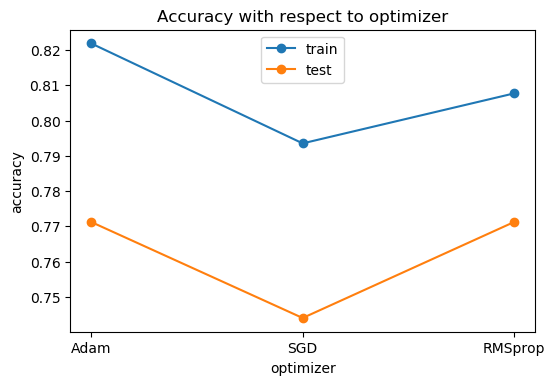

In [19]:
tr_acc = np.mean(train_acc, axis=0)
te_acc = np.mean(test_acc, axis=0)

plt.figure(dpi=100)
plt.plot(tr_acc, marker="o")
plt.plot(te_acc, marker="o")
plt.xticks([0,1,2],["Adam", "SGD", "RMSprop"]);
plt.title("Accuracy with respect to optimizer");
plt.legend(["train", "test"],loc=9);
plt.xlabel("optimizer");
plt.ylabel("accuracy");
plt.savefig("optimizer.png");

In [13]:
# learning rate tuning
list_lr = [.01, .005, .001, .0005, .0001, .00005, .000001]
acc_train = np.zeros((len(list_lr), 5))
acc_test = np.zeros((len(list_lr), 5))

# running each lr 5 times be more precise
for i, lr_ in enumerate(list_lr):
    for j in range(5):
        model = Network()
        model.to(device)

        loss_function = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr_)

        train_acc, test_acc = train(model, optimizer, loss_function, num_epochs=10)
        acc_train[i][j] = train_acc[-1]
        acc_test[i][j] = test_acc[-1]

Accuracy train: 48.8%	 test: 48.1%


Accuracy train: 50.2%	 test: 48.1%


Accuracy train: 50.6%	 test: 48.1%


Accuracy train: 50.9%	 test: 48.1%


Accuracy train: 51.4%	 test: 48.1%


Accuracy train: 50.8%	 test: 48.1%


Accuracy train: 50.0%	 test: 48.1%


Accuracy train: 52.5%	 test: 48.1%


Accuracy train: 51.9%	 test: 48.1%


Accuracy train: 52.6%	 test: 48.1%



Accuracy train: 49.0%	 test: 51.9%


Accuracy train: 48.3%	 test: 51.9%


Accuracy train: 50.5%	 test: 48.1%


Accuracy train: 49.9%	 test: 50.5%


Accuracy train: 51.9%	 test: 51.9%


Accuracy train: 50.0%	 test: 51.9%


Accuracy train: 50.9%	 test: 51.9%


Accuracy train: 49.9%	 test: 49.8%


Accuracy train: 50.6%	 test: 48.1%


Accuracy train: 52.5%	 test: 48.1%



Accuracy train: 50.5%	 test: 51.9%


Accuracy train: 49.4%	 test: 48.1%


Accuracy train: 51.3%	 test: 48.1%


Accuracy train: 50.6%	 test: 51.2%


Accuracy train: 51.2%	 test: 49.0%


Accuracy train: 51.0%	 test: 48.2%


Accuracy train: 51.1%	 test: 51.9%


Accuracy train: 52.0%	 test: 48.1%


Accuracy train: 52.7%	 test: 48.1%


Accuracy train: 50.3%	 test: 51.5%



Accuracy train: 51.7%	 test: 48.1%


Accuracy train: 52.3%	 test: 48.1%


Accuracy train: 51.8%	 test: 48.1%


Accuracy train: 51.3%	 test: 48.1%


Accuracy train: 52.4%	 test: 48.1%


Accuracy train: 52.2%	 test: 48.1%


Accuracy train: 52.3%	 test: 48.1%


Accuracy train: 51.3%	 test: 48.1%


Accuracy train: 52.8%	 test: 51.9%


Accuracy train: 50.8%	 test: 48.1%



Accuracy train: 51.1%	 test: 48.1%


Accuracy train: 49.1%	 test: 48.1%


Accuracy train: 50.8%	 test: 48.1%


Accuracy train: 50.5%	 test: 51.9%


Accuracy train: 52.3%	 test: 48.1%


Accuracy train: 52.5%	 test: 48.1%


Accuracy train: 52.5%	 test: 48.1%


Accuracy train: 51.6%	 test: 48.1%


Accuracy train: 50.7%	 test: 48.1%


Accuracy train: 51.1%	 test: 48.1%



Accuracy train: 51.6%	 test: 51.7%


Accuracy train: 50.4%	 test: 48.1%


Accuracy train: 50.6%	 test: 48.1%


Accuracy train: 51.1%	 test: 48.1%


Accuracy train: 50.5%	 test: 48.1%


Accuracy train: 52.5%	 test: 48.1%


Accuracy train: 50.8%	 test: 51.9%


Accuracy train: 51.7%	 test: 51.9%


Accuracy train: 51.8%	 test: 51.9%


Accuracy train: 49.4%	 test: 51.9%



Accuracy train: 51.1%	 test: 51.9%


Accuracy train: 55.7%	 test: 49.6%


Accuracy train: 52.7%	 test: 49.2%


Accuracy train: 52.9%	 test: 48.1%


Accuracy train: 52.8%	 test: 48.3%


Accuracy train: 53.6%	 test: 48.1%


Accuracy train: 52.5%	 test: 48.1%


Accuracy train: 53.3%	 test: 49.7%


Accuracy train: 50.6%	 test: 48.1%


Accuracy train: 51.6%	 test: 49.1%



Accuracy train: 51.4%	 test: 48.1%


Accuracy train: 51.6%	 test: 48.3%


Accuracy train: 51.8%	 test: 51.9%


Accuracy train: 51.6%	 test: 49.2%


Accuracy train: 53.5%	 test: 51.9%


Accuracy train: 53.5%	 test: 49.4%


Accuracy train: 53.6%	 test: 51.9%


Accuracy train: 52.7%	 test: 51.9%


Accuracy train: 52.6%	 test: 49.8%


Accuracy train: 51.9%	 test: 51.9%



Accuracy train: 51.3%	 test: 48.1%


Accuracy train: 50.6%	 test: 48.1%


Accuracy train: 52.5%	 test: 48.1%


Accuracy train: 50.3%	 test: 48.1%


Accuracy train: 52.5%	 test: 48.1%


Accuracy train: 52.5%	 test: 48.1%


Accuracy train: 52.5%	 test: 48.1%


Accuracy train: 52.5%	 test: 48.1%


Accuracy train: 52.5%	 test: 48.1%


Accuracy train: 52.5%	 test: 48.1%



Accuracy train: 51.7%	 test: 49.6%


Accuracy train: 52.5%	 test: 51.9%


Accuracy train: 50.6%	 test: 51.9%


Accuracy train: 49.9%	 test: 48.1%


Accuracy train: 51.6%	 test: 51.9%


Accuracy train: 51.8%	 test: 48.1%


Accuracy train: 52.4%	 test: 48.1%


Accuracy train: 51.1%	 test: 48.1%


Accuracy train: 50.2%	 test: 48.1%


Accuracy train: 50.6%	 test: 48.3%



Accuracy train: 51.8%	 test: 48.1%


Accuracy train: 52.5%	 test: 48.1%


Accuracy train: 52.5%	 test: 48.1%


Accuracy train: 52.5%	 test: 48.1%


Accuracy train: 52.5%	 test: 48.1%


Accuracy train: 52.3%	 test: 48.1%


Accuracy train: 53.4%	 test: 48.1%


Accuracy train: 52.5%	 test: 48.1%


Accuracy train: 52.5%	 test: 48.1%


Accuracy train: 52.5%	 test: 48.1%



Accuracy train: 55.8%	 test: 65.8%


Accuracy train: 67.9%	 test: 68.5%


Accuracy train: 70.0%	 test: 65.6%


Accuracy train: 72.1%	 test: 62.5%


Accuracy train: 71.7%	 test: 62.5%


Accuracy train: 74.7%	 test: 72.6%


Accuracy train: 76.5%	 test: 58.4%


Accuracy train: 78.0%	 test: 68.9%


Accuracy train: 77.1%	 test: 76.3%


Accuracy train: 78.2%	 test: 74.3%



Accuracy train: 55.6%	 test: 48.1%


Accuracy train: 53.8%	 test: 54.5%


Accuracy train: 68.9%	 test: 65.8%


Accuracy train: 73.0%	 test: 71.3%


Accuracy train: 71.0%	 test: 69.5%


Accuracy train: 74.4%	 test: 70.7%


Accuracy train: 73.8%	 test: 73.3%


Accuracy train: 74.2%	 test: 71.4%


Accuracy train: 76.7%	 test: 74.0%


Accuracy train: 76.5%	 test: 71.7%



Accuracy train: 55.6%	 test: 68.4%


Accuracy train: 73.8%	 test: 72.7%


Accuracy train: 75.1%	 test: 66.6%


Accuracy train: 74.6%	 test: 73.3%


Accuracy train: 75.8%	 test: 72.8%


Accuracy train: 77.1%	 test: 73.5%


Accuracy train: 76.7%	 test: 74.4%


Accuracy train: 77.7%	 test: 76.4%


Accuracy train: 77.1%	 test: 72.9%


Accuracy train: 77.6%	 test: 75.1%



Accuracy train: 55.0%	 test: 48.1%


Accuracy train: 52.5%	 test: 48.1%


Accuracy train: 52.5%	 test: 48.1%


Accuracy train: 52.5%	 test: 48.1%


Accuracy train: 52.5%	 test: 48.1%


Accuracy train: 52.5%	 test: 48.1%


Accuracy train: 52.5%	 test: 48.1%


Accuracy train: 54.3%	 test: 48.1%


Accuracy train: 52.5%	 test: 48.1%


Accuracy train: 52.5%	 test: 48.1%



Accuracy train: 58.7%	 test: 67.2%


Accuracy train: 69.9%	 test: 67.6%


Accuracy train: 74.2%	 test: 72.1%


Accuracy train: 76.1%	 test: 71.2%


Accuracy train: 76.9%	 test: 74.5%


Accuracy train: 76.4%	 test: 75.1%


Accuracy train: 77.8%	 test: 76.0%


Accuracy train: 78.5%	 test: 74.1%


Accuracy train: 79.9%	 test: 75.5%


Accuracy train: 79.6%	 test: 75.2%



Accuracy train: 64.0%	 test: 72.5%


Accuracy train: 74.4%	 test: 72.6%


Accuracy train: 75.0%	 test: 73.0%


Accuracy train: 75.0%	 test: 70.0%


Accuracy train: 76.4%	 test: 73.5%


Accuracy train: 79.0%	 test: 75.1%


Accuracy train: 78.7%	 test: 74.3%


Accuracy train: 78.7%	 test: 75.5%


Accuracy train: 80.3%	 test: 76.7%


Accuracy train: 79.7%	 test: 73.7%



Accuracy train: 62.2%	 test: 70.4%


Accuracy train: 73.6%	 test: 72.0%


Accuracy train: 73.2%	 test: 72.0%


Accuracy train: 77.0%	 test: 73.3%


Accuracy train: 77.7%	 test: 76.1%


Accuracy train: 76.8%	 test: 74.3%


Accuracy train: 77.5%	 test: 73.5%


Accuracy train: 78.1%	 test: 75.3%


Accuracy train: 80.3%	 test: 76.0%


Accuracy train: 79.7%	 test: 75.6%



Accuracy train: 65.3%	 test: 73.4%


Accuracy train: 76.7%	 test: 73.7%


Accuracy train: 76.2%	 test: 74.0%


Accuracy train: 76.6%	 test: 68.1%


Accuracy train: 76.4%	 test: 70.0%


Accuracy train: 76.9%	 test: 74.5%


Accuracy train: 78.9%	 test: 72.4%


Accuracy train: 78.8%	 test: 75.5%


Accuracy train: 80.4%	 test: 75.7%


Accuracy train: 81.3%	 test: 75.3%



Accuracy train: 60.8%	 test: 67.0%


Accuracy train: 72.4%	 test: 71.3%


Accuracy train: 72.6%	 test: 71.9%


Accuracy train: 73.1%	 test: 72.2%


Accuracy train: 74.4%	 test: 69.0%


Accuracy train: 76.5%	 test: 74.9%


Accuracy train: 75.6%	 test: 73.5%


Accuracy train: 77.0%	 test: 76.2%


Accuracy train: 79.0%	 test: 74.3%


Accuracy train: 79.3%	 test: 70.1%



Accuracy train: 63.8%	 test: 66.0%


Accuracy train: 71.6%	 test: 67.0%


Accuracy train: 73.7%	 test: 72.8%


Accuracy train: 75.3%	 test: 74.8%


Accuracy train: 76.6%	 test: 72.9%


Accuracy train: 78.0%	 test: 75.7%


Accuracy train: 78.3%	 test: 74.5%


Accuracy train: 80.1%	 test: 76.6%


Accuracy train: 80.7%	 test: 74.9%


Accuracy train: 79.8%	 test: 76.5%



Accuracy train: 62.5%	 test: 70.9%


Accuracy train: 73.0%	 test: 72.2%


Accuracy train: 73.6%	 test: 73.1%


Accuracy train: 76.3%	 test: 69.8%


Accuracy train: 75.6%	 test: 74.0%


Accuracy train: 77.8%	 test: 74.8%


Accuracy train: 79.0%	 test: 75.3%


Accuracy train: 78.9%	 test: 73.6%


Accuracy train: 79.8%	 test: 75.3%


Accuracy train: 80.0%	 test: 77.0%



Accuracy train: 65.7%	 test: 67.0%


Accuracy train: 73.2%	 test: 68.8%


Accuracy train: 73.6%	 test: 67.7%


Accuracy train: 74.5%	 test: 71.5%


Accuracy train: 76.2%	 test: 74.1%


Accuracy train: 76.0%	 test: 74.5%


Accuracy train: 76.8%	 test: 73.5%


Accuracy train: 78.2%	 test: 75.4%


Accuracy train: 77.4%	 test: 75.7%


Accuracy train: 79.4%	 test: 76.1%



Accuracy train: 61.1%	 test: 62.1%


Accuracy train: 71.7%	 test: 72.4%


Accuracy train: 73.5%	 test: 70.8%


Accuracy train: 74.7%	 test: 73.2%


Accuracy train: 76.5%	 test: 72.9%


Accuracy train: 75.6%	 test: 72.8%


Accuracy train: 78.0%	 test: 75.5%


Accuracy train: 78.6%	 test: 76.2%


Accuracy train: 78.3%	 test: 76.0%


Accuracy train: 80.0%	 test: 75.6%



Accuracy train: 55.8%	 test: 54.2%


Accuracy train: 68.7%	 test: 70.7%


Accuracy train: 73.1%	 test: 72.3%


Accuracy train: 74.4%	 test: 70.8%


Accuracy train: 73.5%	 test: 73.4%


Accuracy train: 76.2%	 test: 73.8%


Accuracy train: 77.6%	 test: 75.4%


Accuracy train: 79.4%	 test: 76.8%


Accuracy train: 78.0%	 test: 75.0%


Accuracy train: 79.0%	 test: 76.9%



Accuracy train: 62.6%	 test: 69.8%


Accuracy train: 72.0%	 test: 69.3%


Accuracy train: 73.3%	 test: 71.4%


Accuracy train: 74.5%	 test: 72.6%


Accuracy train: 75.4%	 test: 72.4%


Accuracy train: 75.8%	 test: 74.1%


Accuracy train: 77.7%	 test: 73.8%


Accuracy train: 77.8%	 test: 76.2%


Accuracy train: 78.1%	 test: 77.0%


Accuracy train: 77.3%	 test: 76.1%



Accuracy train: 61.1%	 test: 68.2%


Accuracy train: 70.6%	 test: 70.6%


Accuracy train: 73.2%	 test: 72.4%


Accuracy train: 74.6%	 test: 71.1%


Accuracy train: 74.9%	 test: 72.8%


Accuracy train: 76.7%	 test: 73.5%


Accuracy train: 75.3%	 test: 75.5%


Accuracy train: 77.6%	 test: 75.3%


Accuracy train: 79.9%	 test: 75.6%


Accuracy train: 79.2%	 test: 74.9%



Accuracy train: 62.4%	 test: 69.4%


Accuracy train: 71.8%	 test: 66.3%


Accuracy train: 72.7%	 test: 72.1%


Accuracy train: 74.1%	 test: 72.2%


Accuracy train: 74.6%	 test: 72.1%


Accuracy train: 75.3%	 test: 74.4%


Accuracy train: 76.3%	 test: 73.8%


Accuracy train: 77.9%	 test: 75.1%


Accuracy train: 76.8%	 test: 75.1%


Accuracy train: 77.3%	 test: 74.8%



Accuracy train: 60.9%	 test: 66.3%


Accuracy train: 70.1%	 test: 70.0%


Accuracy train: 72.6%	 test: 71.2%


Accuracy train: 72.9%	 test: 73.0%


Accuracy train: 75.0%	 test: 72.9%


Accuracy train: 74.2%	 test: 71.5%


Accuracy train: 75.6%	 test: 74.3%


Accuracy train: 77.1%	 test: 74.0%


Accuracy train: 76.9%	 test: 74.0%


Accuracy train: 77.1%	 test: 73.2%



Accuracy train: 62.4%	 test: 66.9%


Accuracy train: 71.4%	 test: 69.0%


Accuracy train: 73.2%	 test: 67.9%


Accuracy train: 74.4%	 test: 71.8%


Accuracy train: 74.6%	 test: 73.8%


Accuracy train: 73.9%	 test: 72.7%


Accuracy train: 75.9%	 test: 74.4%


Accuracy train: 77.5%	 test: 75.3%


Accuracy train: 78.6%	 test: 73.8%


Accuracy train: 79.4%	 test: 75.5%



Accuracy train: 53.0%	 test: 48.1%


Accuracy train: 52.7%	 test: 48.1%


Accuracy train: 52.9%	 test: 48.1%


Accuracy train: 52.6%	 test: 48.1%


Accuracy train: 52.5%	 test: 48.1%


Accuracy train: 52.6%	 test: 48.1%


Accuracy train: 52.5%	 test: 48.1%


Accuracy train: 52.5%	 test: 48.2%


Accuracy train: 54.4%	 test: 51.4%


Accuracy train: 56.6%	 test: 54.0%



Accuracy train: 51.9%	 test: 48.1%


Accuracy train: 52.6%	 test: 48.1%


Accuracy train: 52.7%	 test: 48.1%


Accuracy train: 52.5%	 test: 48.1%


Accuracy train: 52.6%	 test: 48.1%


Accuracy train: 52.7%	 test: 48.1%


Accuracy train: 52.7%	 test: 48.1%


Accuracy train: 53.3%	 test: 50.5%


Accuracy train: 57.8%	 test: 57.4%


Accuracy train: 63.3%	 test: 63.1%



Accuracy train: 47.5%	 test: 51.9%


Accuracy train: 51.2%	 test: 51.8%


Accuracy train: 55.5%	 test: 57.6%


Accuracy train: 53.9%	 test: 53.9%


Accuracy train: 52.9%	 test: 50.5%


Accuracy train: 53.0%	 test: 50.7%


Accuracy train: 53.0%	 test: 52.1%


Accuracy train: 52.9%	 test: 55.6%


Accuracy train: 58.2%	 test: 63.6%


Accuracy train: 60.3%	 test: 64.4%



Accuracy train: 50.0%	 test: 51.9%


Accuracy train: 53.2%	 test: 54.5%


Accuracy train: 52.3%	 test: 48.1%


Accuracy train: 52.5%	 test: 48.1%


Accuracy train: 52.7%	 test: 48.1%


Accuracy train: 52.5%	 test: 48.1%


Accuracy train: 52.5%	 test: 48.2%


Accuracy train: 52.4%	 test: 48.5%


Accuracy train: 52.7%	 test: 51.4%


Accuracy train: 53.3%	 test: 57.3%



Accuracy train: 52.4%	 test: 48.1%


Accuracy train: 52.5%	 test: 48.1%


Accuracy train: 52.5%	 test: 48.1%


Accuracy train: 52.5%	 test: 48.1%


Accuracy train: 52.5%	 test: 48.1%


Accuracy train: 52.5%	 test: 48.1%


Accuracy train: 52.5%	 test: 48.1%


Accuracy train: 52.6%	 test: 48.1%


Accuracy train: 52.5%	 test: 48.1%


Accuracy train: 53.4%	 test: 48.6%



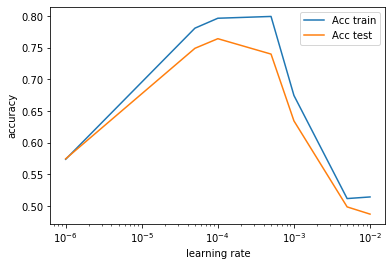

In [15]:
acc_train_ = np.mean(acc_train, axis=1)
acc_test_ = np.mean(acc_test, axis=1)

plt.figure()
plt.semilogx(list_lr, acc_train_)
plt.semilogx(list_lr, acc_test_)
plt.legend(["Acc train", "Acc test"]);
plt.xlabel("learning rate");
plt.ylabel("accuracy");
plt.savefig("learning_rate_tuning.png");

<h2> Missclassified

In [19]:
def get_misclassified(model):
    model.eval()
    
    test_images, test_labels, misclassified = [], [], []
    for i, (data, target) in enumerate(test_loader):
        data = data.to(device)
        target = target.to(device)
        test_images.extend(data)
        test_labels.extend(target)

        with torch.no_grad():
            output = model(data)

        predicted = output.argmax(1)

        for ii, elt in enumerate(predicted):
            if elt != target[ii]:
                misclassified.append(64 * i + ii)
    
    random.shuffle(misclassified)
    
    images_misclassified = [test_images[i] for i in misclassified]
    labels_misclassified = [test_labels[i] for i in misclassified]
    return images_misclassified, labels_misclassified

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


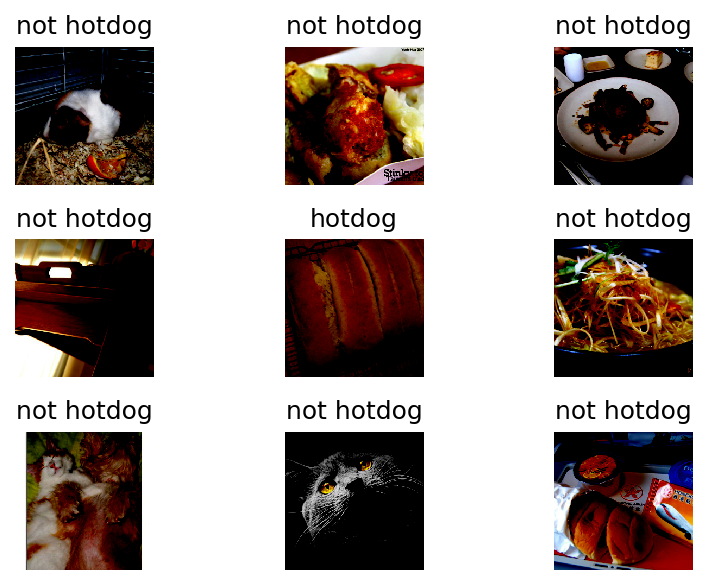

In [20]:
# analyzing misclassified images

torch.cuda.empty_cache() # freeing reusable memory

model = Network()
model.to(device)
model.load_state_dict(torch.load("hotdog.pth"));
img, lab = get_misclassified(model)

plt.figure(dpi=150)
for i in range(9):
    plt.subplot(3,3,i+1);
    plt.imshow(np.swapaxes(np.swapaxes(img[i].cpu().numpy(), 0, 2), 0, 1));
    plt.title(['hotdog', 'not hotdog'][lab[i]]);
    plt.axis('off');
    
plt.tight_layout()   
plt.savefig("missclassified.png")

<h2> Try to predict individual images instead of batches

In [ ]:
def predict_image(image):
    image_tensor = test_transform(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_ = Variable(image_tensor)
    input_ = input_.to(device)
    output = model(input_)
    index = output.data.cpu().numpy().argmax()
    return index

In [ ]:
def get_random_images(num):
    data = Hotdog_NotHotdog(train=False, transform=test_transform)
    
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = DataLoader(data,sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

In [ ]:
to_pil = transforms.ToPILImage()

images, labels = get_random_images(5)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = ((images[ii] * .5) + .5)
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(['hotdog', 'not hotdog'][labels[ii].item()]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()